## 1. Introduction

The goal of this project is to apply decision tree classification techniques on the Lichess chess dataset to predict the victory status of games, which includes outcomes such as checkmate, resignation, timeout, or draw. By analyzing various features such as player ratings, the number of moves, opening strategies, and game duration, we aim to identify the factors most strongly associated with each victory type. Through the decision tree model, we will explore how different variables influence game outcomes, visualize decision paths, and interpret the model's predictive power in determining victory status.

## 2. Preprocessing Data

In this step, we prepare the chess dataset for analysis and model training.
<ol>
<li>We load the dataset and clean it by removing irrelevant columns (id) and separating our target variable (opening_eco) from the features.</li>
<li> We apply label encoding the categorical values to transform these categories into numeric values. </li> 
<li> We split the processed data into training and test sets, reserving 20% of the data for testing </li>

In [15]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
data_path = '../../data/raw_data/chess/games.csv'  
df = pd.read_csv(data_path)  

# Drop irrelevant columns for this prediction task
x = df.drop(columns=['id', 'rated', 'created_at', 'last_move_at', 'victory_status',
       'winner', 'white_id',  'black_id','moves'])  
y = df['victory_status'] 

# Encode categorical features as numeric values
label_encoder = preprocessing.LabelEncoder()  
x = x.apply(label_encoder.fit_transform)  
y = label_encoder.fit_transform(y)

# Split the dataset into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=4)  


### Evaluating Train-Test Split Ratios

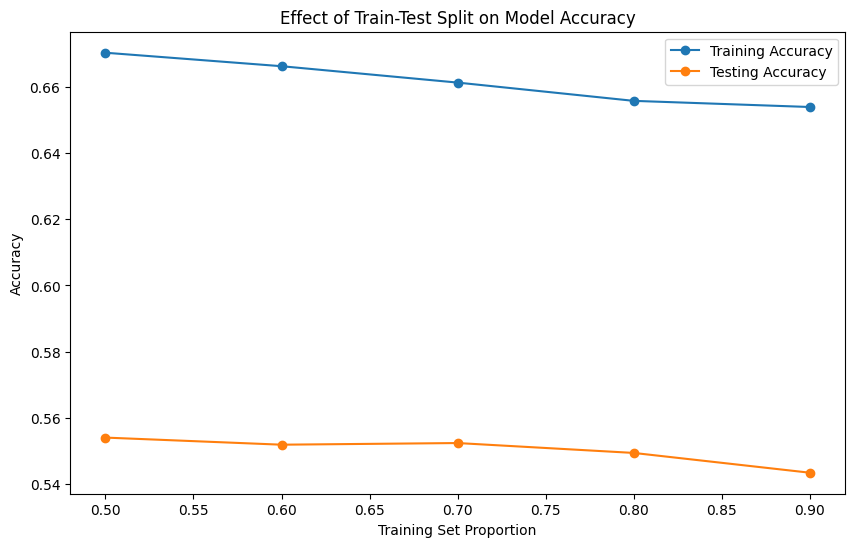

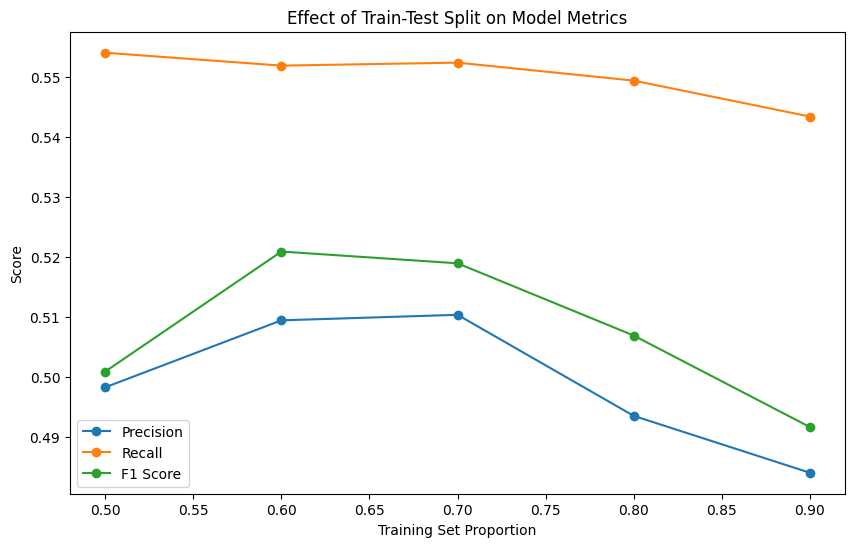

In [16]:
# Define the different train-test splits to evaluate
split_ratios = [0.9, 0.8, 0.7, 0.6, 0.5]

# Initialize lists to store results
train_accuracies = []
test_accuracies = []
precision_scores = []
recall_scores = []
f1_scores = []

# Loop over different split ratios
for split in split_ratios:
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=(1 - split), random_state=42)
    
    # Initialize and train the Decision Tree classifier
    clf = DecisionTreeClassifier(max_depth=10, random_state=42)
    clf.fit(X_train, y_train)
    
    # Evaluate on training data
    y_train_pred = clf.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    
    # Evaluate on testing data
    y_test_pred = clf.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred, average='weighted')
    recall = recall_score(y_test, y_test_pred, average='weighted')
    f1 = f1_score(y_test, y_test_pred, average='weighted')
    
    # Store the results
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

# Plot Training vs Testing Accuracy
plt.figure(figsize=(10, 6))
plt.plot(split_ratios, train_accuracies, marker='o', label='Training Accuracy')
plt.plot(split_ratios, test_accuracies, marker='o', label='Testing Accuracy')
plt.title("Effect of Train-Test Split on Model Accuracy")
plt.xlabel("Training Set Proportion")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Plot Precision, Recall, and F1-Score for each split
plt.figure(figsize=(10, 6))
plt.plot(split_ratios, precision_scores, marker='o', label='Precision')
plt.plot(split_ratios, recall_scores, marker='o', label='Recall')
plt.plot(split_ratios, f1_scores, marker='o', label='F1 Score')
plt.title("Effect of Train-Test Split on Model Metrics")
plt.xlabel("Training Set Proportion")
plt.ylabel("Score")
plt.legend()
plt.show()

#### Evaluation Results
##### Optimal Split Ratio
The best train-test split ratio appears to be around 0.7 for training data. This split shows a balance between training and testing accuracy, where both metrics are high, and the difference between them is minimal, indicating good generalization.

##### Effect of Training Data Size
As the training set size increases, the testing accuracy improves up to a point, showing that additional data helps the model learn patterns better. However, beyond the 70% training split, the benefits diminish, and the model’s testing accuracy stabilizes or slightly decreases. This indicates that more data doesn’t necessarily equate to better testing performance after a certain threshold.

##### Overfitting and Underfitting Analysis
1. Underfitting: The smaller training sizes (e.g., 50%) show reduced performance, which suggests underfitting, as the model lacks sufficient data to capture complex patterns.
2. Overfitting: With a high training proportion (e.g., 90%), we see a significant gap between training and testing accuracy, suggesting overfitting. The model performs well on the training data but doesn’t generalize effectively to the test data.
In summary, a 70% training and 30% testing split provides the best generalization, balancing accuracy across both datasets and avoiding overfitting or underfitting.

### Evaluating Model Stability using Cross-Validation

`cross_validate performs` k-fold cross-validation, here with `cv=5`, and returns both training and testing scores for each fold.

We compute the average of the `train_score` and `test_score` across all folds to get an overall sense of the model's performance.

This approach provides a robust evaluation of how well the model generalizes, with training and testing scores averaged over multiple splits.

In [17]:
# Initialize the Decision Tree model with chosen parameters
clf = DecisionTreeClassifier(max_depth=30, random_state=1)

# Perform k-fold cross-validation with k=5
k = 5
cv_results = cross_validate(clf, x, y, cv=k, return_train_score=True)

# Calculate the average training and validation (testing) scores
average_training_score = np.mean(cv_results['train_score'])
average_validation_score = np.mean(cv_results['test_score'])

print(f"Average Training Accuracy across {k} folds: {average_training_score:.4f}")
print(f"Average Validation Accuracy across {k} folds: {average_validation_score:.4f}")

Average Training Accuracy across 5 folds: 0.9967
Average Validation Accuracy across 5 folds: 0.4925


## 3. Hyperparameter Testing

### Choose Hyperparameters to Test

The main Decision Tree hyperparameters that significantly impact model performance are:
<ol>
<li>max_depth: Maximum depth of the tree. Controls how deep the tree can grow, influencing complexity and overfitting.</li>
<li>min_samples_split: Minimum number of samples required to split an internal node. Larger values prevent splitting on small sample sizes, reducing overfitting.</li>
<li>min_samples_leaf: Minimum number of samples required to be at a leaf node. Higher values smooth the model, reducing overfitting.</li>
<li>criterion: The function to measure the quality of a split. Options are gini (default) and entropy. This affects how the tree selects the best splits.</li>
</ol>

### Set Up a Baseline Model
Start by establishing a baseline model with default parameters. This will serve as a comparison point.

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
# Split the dataset into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=4)  

# Create and train a baseline model
baseline_clf = DecisionTreeClassifier(random_state=1)
baseline_clf.fit(x_train, y_train)

# Predict and evaluate
baseline_y_pred = baseline_clf.predict(x_test)
baseline_accuracy = accuracy_score(y_test, baseline_y_pred)
print("Baseline Model Accuracy:", baseline_accuracy)

Baseline Model Accuracy: 0.48338318378198736


### Experiment with `max_depth`
Varying `max_depth` can help you understand how deep the tree should be to capture meaningful patterns without overfitting. Typically, shallower trees generalize better, while deeper trees capture more detail but risk overfitting.
<ol>
<li>Train models with different max_depth values.
<li>Plot accuracy scores on both training and testing sets to see if increasing depth leads to overfitting.
</ol>

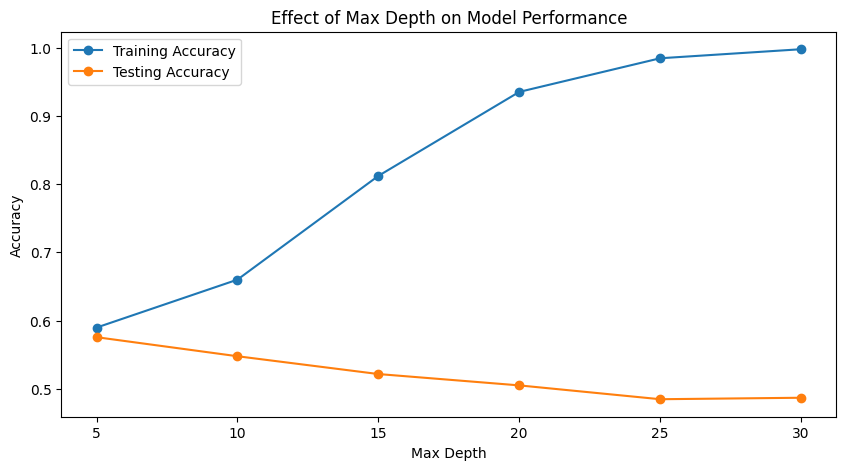

In [19]:
import matplotlib.pyplot as plt

train_accuracies = []
test_accuracies = []
max_depth_values = [5, 10, 15, 20, 25, 30, None]

for depth in max_depth_values:
    clf = DecisionTreeClassifier(max_depth=depth, random_state=1)
    clf.fit(x_train, y_train)
    
    train_accuracies.append(clf.score(x_train, y_train))
    test_accuracies.append(clf.score(x_test, y_test))

plt.figure(figsize=(10, 5))
plt.plot(max_depth_values, train_accuracies, label='Training Accuracy', marker='o')
plt.plot(max_depth_values, test_accuracies, label='Testing Accuracy', marker='o')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Effect of Max Depth on Model Performance')
plt.legend()
plt.show()


### Experiment with `min_samples_split`
`min_samples_split` controls the minimum number of samples required to split an internal node. Higher values generally reduce overfitting by forcing the tree to consider splits with larger sample sizes.
<ol>
<li>Test different values.
<li>Similar to max_depth, track training and testing accuracy and plot the results.
</ol>

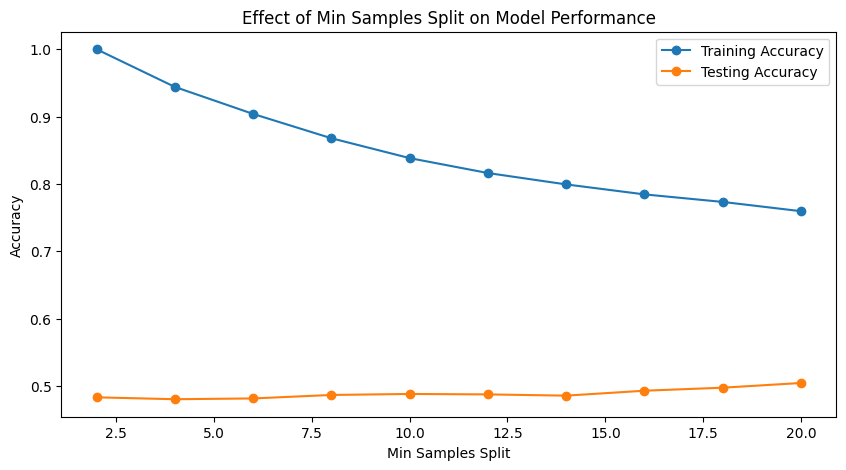

In [20]:
min_samples_split_values = [2,4,6,8,10,12,14,16,18,20]
train_accuracies_split = []
test_accuracies_split = []

for min_split in min_samples_split_values:
    clf = DecisionTreeClassifier(min_samples_split=min_split, random_state=1)
    clf.fit(x_train, y_train)
    
    train_accuracies_split.append(clf.score(x_train, y_train))
    test_accuracies_split.append(clf.score(x_test, y_test))

plt.figure(figsize=(10, 5))
plt.plot(min_samples_split_values, train_accuracies_split, label='Training Accuracy', marker='o')
plt.plot(min_samples_split_values, test_accuracies_split, label='Testing Accuracy', marker='o')
plt.xlabel('Min Samples Split')
plt.ylabel('Accuracy')
plt.title('Effect of Min Samples Split on Model Performance')
plt.legend()
plt.show()

### Experiment with `min_samples_leaf`
`min_samples_leaf` ensures that leaf nodes have at least a certain number of samples, which can also reduce overfitting by making the model more general.

<ol>
<li>Test different values.
<li>Plot the training and testing accuracy as before.
</ol>

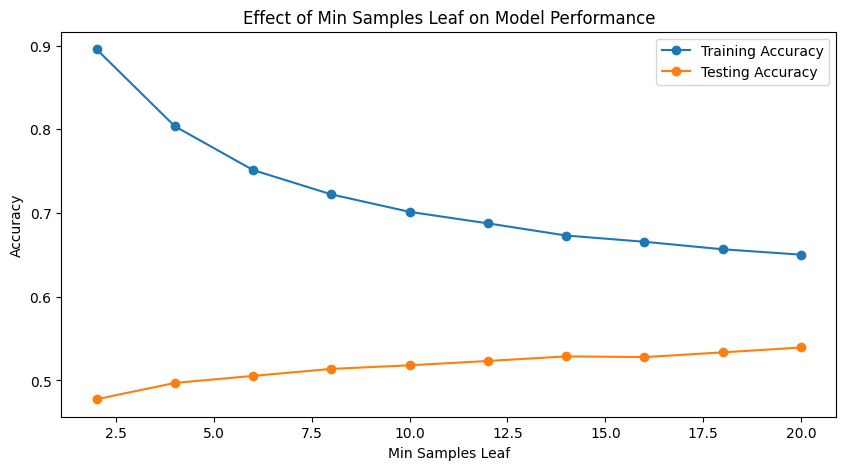

In [21]:
min_samples_leaf_values = [2,4,6,8,10,12,14,16,18,20]
train_accuracies_leaf = []
test_accuracies_leaf = []

for min_leaf in min_samples_leaf_values:
    clf = DecisionTreeClassifier(min_samples_leaf=min_leaf, random_state=1)
    clf.fit(x_train, y_train)
    
    train_accuracies_leaf.append(clf.score(x_train, y_train))
    test_accuracies_leaf.append(clf.score(x_test, y_test))

plt.figure(figsize=(10, 5))
plt.plot(min_samples_leaf_values, train_accuracies_leaf, label='Training Accuracy', marker='o')
plt.plot(min_samples_leaf_values, test_accuracies_leaf, label='Testing Accuracy', marker='o')
plt.xlabel('Min Samples Leaf')
plt.ylabel('Accuracy')
plt.title('Effect of Min Samples Leaf on Model Performance')
plt.legend()
plt.show()


### Experiment with `criterion` (Gini vs. Entropy)
The choice of criterion can affect the splits. Try both gini and entropy to see if one performs better for your dataset.

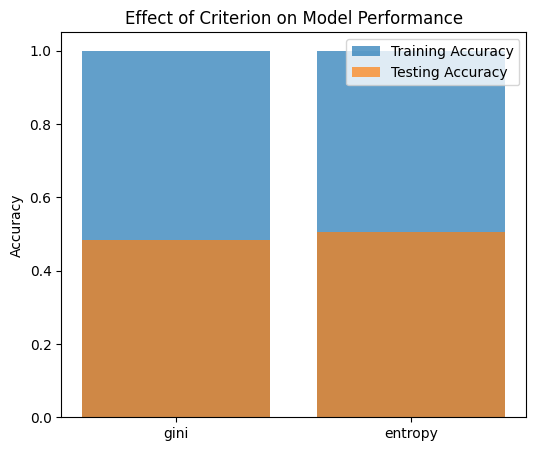

In [22]:
criteria = ['gini', 'entropy']
train_accuracies_criteria = []
test_accuracies_criteria = []

for criterion in criteria:
    clf = DecisionTreeClassifier(criterion=criterion, random_state=1)
    clf.fit(x_train, y_train)
    
    train_accuracies_criteria.append(clf.score(x_train, y_train))
    test_accuracies_criteria.append(clf.score(x_test, y_test))

plt.figure(figsize=(6, 5))
plt.bar(criteria, train_accuracies_criteria, alpha=0.7, label='Training Accuracy')
plt.bar(criteria, test_accuracies_criteria, alpha=0.7, label='Testing Accuracy')
plt.ylabel('Accuracy')
plt.title('Effect of Criterion on Model Performance')
plt.legend()
plt.show()

### Analyzing Results Based on Graphs
1. Optimal Parameter Settings:

    `Max Depth`: The model performance improves with increasing depth, with the training accuracy nearing 100% at higher depths. However, the testing accuracy plateaus around a max depth of 20, suggesting diminishing returns and potential overfitting beyond this point.  
    `Min Samples Split`: The testing accuracy remains relatively stable, while training accuracy drops as min samples split increases. Lower values around 2 to 5 maintain high training accuracy, but larger values reduce overfitting by generalizing better.  
    `Min Samples Leaf`: The training and testing accuracies both decline as this parameter increases, with lower values (e.g., 1 to 5) offering the best balance between accuracy and model complexity.  
    `Criterion` (Gini vs. Entropy): Both criteria yield similar performance. Testing accuracy remains consistent across criteria, indicating that either Gini or Entropy can be chosen without significantly affecting accuracy.  

2. Overfitting and Underfitting Evaluation:

    `Overfitting`: High training accuracy combined with a slightly lower testing accuracy for low min_samples_split and min_samples_leaf values suggests that the model overfits with very low settings.  
    `Underfitting`: Higher values for parameters like min_samples_split (e.g., >15) and min_samples_leaf (e.g., >15) lead to lower accuracies, implying underfitting due to reduced model complexity.  

## 4. Model Creation

We create a Decision Tree classifier with specific hyperparameters to predict the opening type (opening_eco) in chess games. After training the model on the training dataset, we evaluate it on the test set, achieving an accuracy score that helps gauge its predictive performance.

In [23]:
clf = DecisionTreeClassifier(
    max_depth=5,               # Limit the depth of the tree
    min_samples_split=2,        # Minimum samples to split a node
    min_samples_leaf=1,         # Minimum samples in a leaf node
    criterion="gini",        # Measure split quality with Gini index
    random_state=1
)
clf = clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

print("Accuracy:",accuracy_score(y_test, y_pred))

Accuracy: 0.5757726819541376


## 5. Data Visualization

### Full Decision Tree Structure

This comprehensive representation shows each decision node, feature splits, and predicted classes, allowing a detailed examination of the model's decision-making process. The color-filled nodes help in quickly identifying dominant classes at each split, enhancing interpretability.

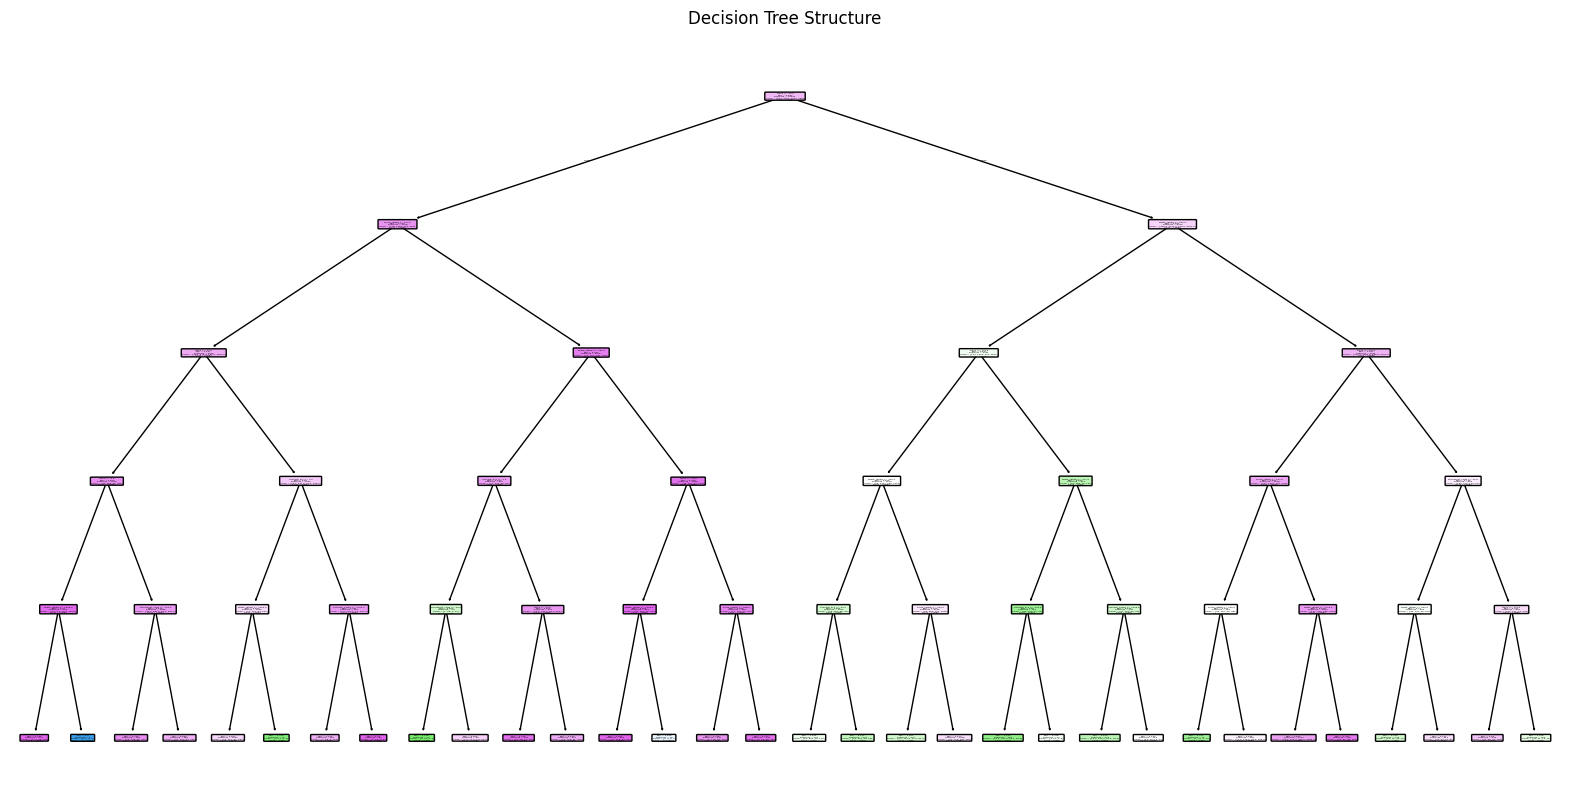

In [24]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plot_tree(
    clf,
    feature_names=x.columns,
    class_names=label_encoder.classes_,
    filled=True,
    rounded=True
)
plt.title("Decision Tree Structure")
plt.show()

### Textual Tree Representation

We use export_text to output a textual representation of the tree structure. This format provides a compact and linear view of the decision rules used by the model, detailing each decision path.

In [ ]:
from sklearn.tree import export_text

tree_text = export_text(clf, feature_names=x.columns.tolist())
print(tree_text)

|--- turns <= 45.50
|   |--- black_rating <= 627.50
|   |   |--- turns <= 27.50
|   |   |   |--- turns <= 5.50
|   |   |   |   |--- white_rating <= 1078.00
|   |   |   |   |   |--- class: 3
|   |   |   |   |--- white_rating >  1078.00
|   |   |   |   |   |--- class: 2
|   |   |   |--- turns >  5.50
|   |   |   |   |--- increment_code <= 125.00
|   |   |   |   |   |--- class: 3
|   |   |   |   |--- increment_code >  125.00
|   |   |   |   |   |--- class: 3
|   |   |--- turns >  27.50
|   |   |   |--- opening_ply <= 4.50
|   |   |   |   |--- white_rating <= 1150.00
|   |   |   |   |   |--- class: 3
|   |   |   |   |--- white_rating >  1150.00
|   |   |   |   |   |--- class: 1
|   |   |   |--- opening_ply >  4.50
|   |   |   |   |--- opening_name <= 1109.00
|   |   |   |   |   |--- class: 3
|   |   |   |   |--- opening_name >  1109.00
|   |   |   |   |   |--- class: 3
|   |--- black_rating >  627.50
|   |   |--- white_rating <= 663.50
|   |   |   |--- opening_eco <= 2.50
|   |   |   |   |

### Feature Importance
Finally, we visualize feature importance scores derived from the trained model. This bar chart ranks the features based on their contribution to the model's predictive accuracy. We can conlcude that `opening_name` is the most important feature, followed by `moves` and `opening_ply`

In [10]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(x.shape[1]), importances[indices], align="center")
plt.xticks(range(x.shape[1]), x.columns[indices], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.show()


NotFittedError: This DecisionTreeClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

### Top 10 Most Frequent Openings/ECO Codes with Victory Status
This heatmap focusing on the top 10 most frequent opening names or ECO codes simplifies the heatmap, providing clearer insights into the relationship between opening choice and victory status. 

For instance, the `Sicilian Defense` and `Sicilian Defense: Bowdler Attack` show a high number of games ending in resignation, while `Van't Kruijs Opening` and `Scandinavian Defense: Mieses-Kotroc Variation` tend to lead to more frequent checkmates. Additionally, some openings like `Scotch Game` and `Sicilian Defense` are associated with longer games, as seen by higher counts in the `outoftime` category.

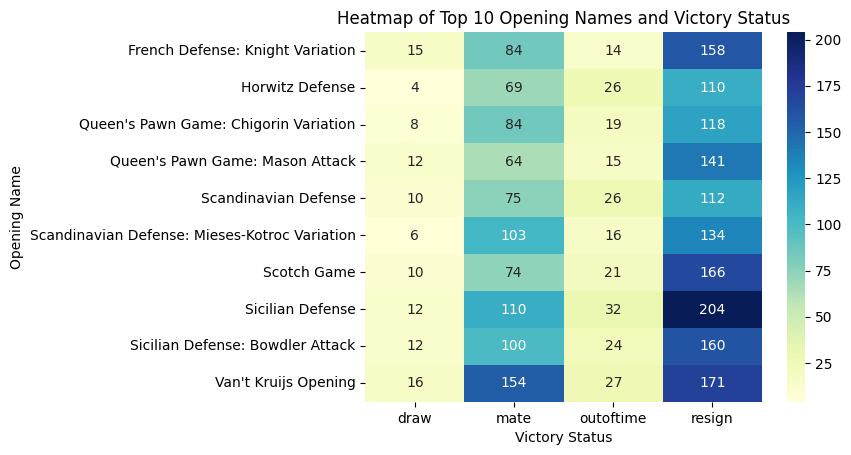

In [ ]:
# Get the top 10 most frequent opening names
top_openings = df['opening_name'].value_counts().head(10).index
filtered_df = df[df['opening_name'].isin(top_openings)]

# Plot heatmap for top 10 openings
opening_victory_status = pd.crosstab(filtered_df['opening_name'], filtered_df['victory_status'])
sns.heatmap(opening_victory_status, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Heatmap of Top 10 Opening Names and Victory Status")
plt.xlabel("Victory Status")
plt.ylabel("Opening Name")
plt.show()


### Stacked Bar Chart for Victory Status by ECO Prefix

The stacked bar chart provides a proportional view of victory statuses within each ECO prefix category (A, B, C, D, E). It reveals that certain victory statuses are more common within specific ECO prefixes, highlighting variations in game outcomes based on opening families. 

For instance,`resign` appears to be a consistently dominant outcome across all ECO prefixes, while `mate` and `outoftime` outcomes show less prevalence.

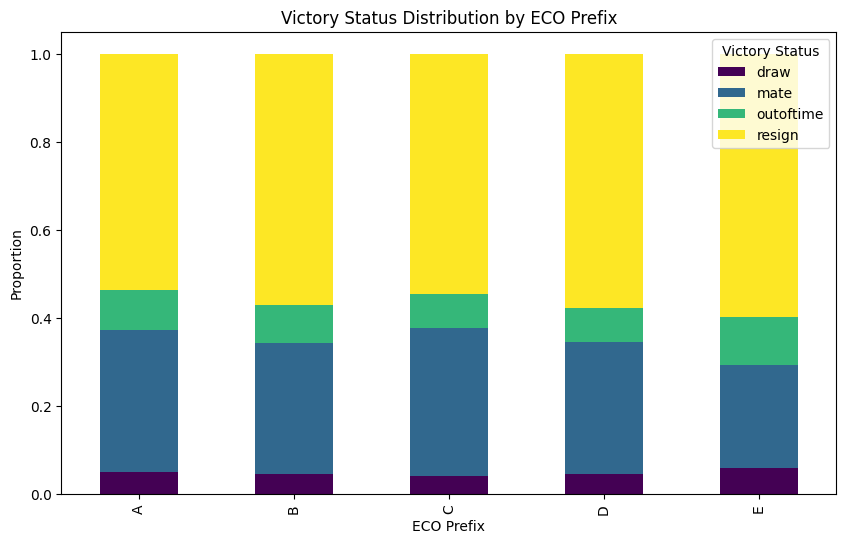

In [ ]:
# Group by ECO prefix and calculate victory status counts
df['eco_prefix'] = df['opening_eco'].str[0]
eco_victory_status = pd.crosstab(df['eco_prefix'], df['victory_status'])

eco_victory_status_norm = eco_victory_status.div(eco_victory_status.sum(axis=1), axis=0)
eco_victory_status_norm.plot(kind='bar', stacked=True, colormap="viridis", figsize=(10, 6))
plt.title("Victory Status Distribution by ECO Prefix")
plt.xlabel("ECO Prefix")
plt.ylabel("Proportion")
plt.legend(title="Victory Status")
plt.show()

### Box Plot of Opening Ply by Victory Status

The box plot of opening ply by victory status provides insights into the distribution of opening depth (ply) for different game outcomes. It shows that the median opening ply is similar across all victory statuses, suggesting that the depth of the opening phase does not drastically vary based on the game outcome. 

However, we can observe that draws tend to have a slightly broader range and higher outliers compared to other outcomes, indicating that games ending in a draw may involve more complex or extended opening phases

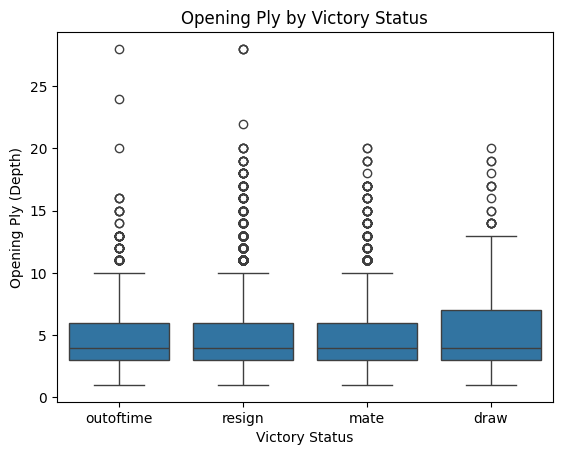

In [ ]:
sns.boxplot(x="victory_status", y="opening_ply", data=df)
plt.title("Opening Ply by Victory Status")
plt.xlabel("Victory Status")
plt.ylabel("Opening Ply (Depth)")
plt.show()


### Number of Moves vs. Victory Status Scatter Plot
This scatter plot visualizes the relationship between the number of moves in a chess game and the corresponding victory status. Each victory outcome—whether it's checkmate, resignation, timeout, or draw—is represented by a distinct color.

The plot reveals that different victory statuses are associated with varying game lengths. Games that end in `mate` and `resign` tend to cluster around shorter and medium game lengths. `Draws`, however, are more commonly associated with longer games, while `outoftime` are dispersed across varying move counts, indicating they can occur at any stage, though they slightly lean toward games with fewer moves. 

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot
strip_plot = sns.stripplot(x="turns", y="victory_status", data=df, jitter=True, hue="victory_status", palette="Set1", dodge=True)
plt.title("Number of Moves vs Victory Status")
plt.xlabel("Number of Moves")
plt.ylabel("Victory Status")

# Manually create a legend
handles, labels = strip_plot.get_legend_handles_labels()
plt.legend(handles=handles[:len(df['victory_status'].unique())], title="Victory Status")

plt.show()


NameError: name 'df' is not defined

### Box Plot of Player Ratings by Victory Status

This plot illustrates the distribution of player ratings for each victory status, separately for white and black players. The box plots show the spread of ratings for games ending in `mate`, `resign`, `outoftime`, and `draw`.

The plot indicates that draws are more common in games with higher-rated players, as evidenced by the slightly higher median ratings in the `draw` category for both white and black players. 

Games that end in `resign` or `mate` tend to have a more balanced range of player ratings, with similar distributions for both players. 

Games ending due to `outoftime` appear to involve players across a wider range of ratings, suggesting that timeout outcomes are not as strongly correlated with player skill level as draws are.

In [12]:
df_melted = df.melt(id_vars="victory_status", value_vars=["white_rating", "black_rating"], var_name="player", value_name="rating")
sns.boxplot(x="victory_status", y="rating", hue="player", data=df_melted)
plt.title("Player Ratings by Victory Status")
plt.xlabel("Victory Status")
plt.ylabel("Player Rating")
plt.legend(title="Player")
plt.show()


NameError: name 'df' is not defined